In [19]:
import pandas as pd
from datetime import datetime
import math

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

# portfolio of stocks
stocks = ['SPY']

start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# # Download historical data from yf API
# data = yf.download(stocks, start=start_date, end=end_date, group_by='ticker')

# # download data to csv
# data.to_csv("spy_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("spy_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# drop Level 0
df.columns = df.columns.droplevel(0)

# Show the result
df.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,298.180692,299.424883,297.249847,299.406433,59151200.0
2020-01-03,295.987167,298.272792,295.931872,297.139191,77709700.0
2020-01-06,295.369735,298.355800,295.249920,298.272858,55653900.0
2020-01-07,297.701484,298.180744,296.982622,297.434235,40496400.0
2020-01-08,297.627664,300.245059,297.378837,299.019318,68296000.0


### Standard Deviation

In [ ]:
data = df.copy()

# rename columns
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

: 

In [ ]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result
    
# plot the result with a title
std = standard_deviation(data, window=30, trading_periods=252, clean=True)
std.plot(title='SPY Standard Deviation', figsize=(10, 5));

### Parkinson

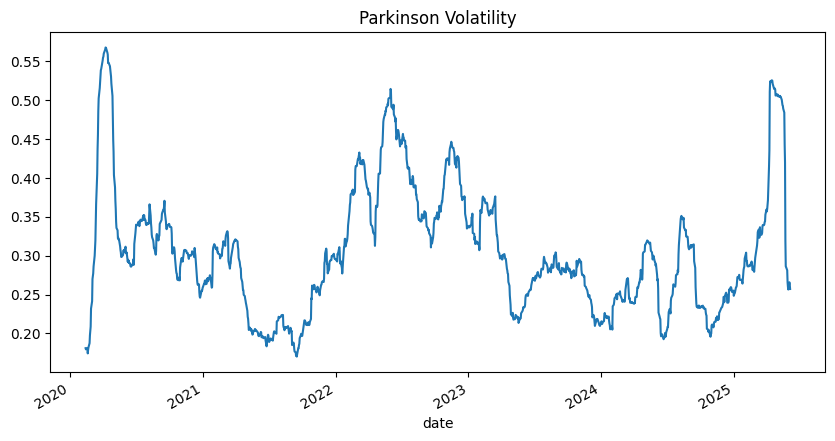

In [ ]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
    
# plot the result with a title
parkinson(data).plot(title='Parkinson Volatility', figsize=(10, 5));

### Garman-Klass

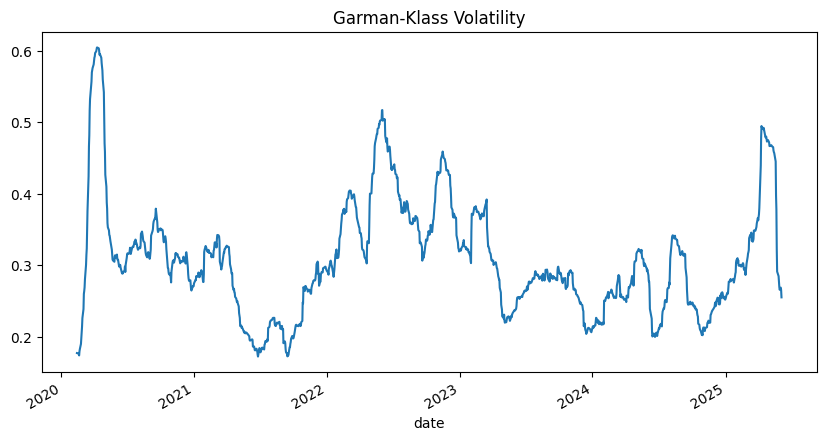

In [ ]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
    
# plot the result with a title
garman_klass(data).plot(title='Garman-Klass Volatility', figsize=(10, 5));

### Hodges-Tompkins

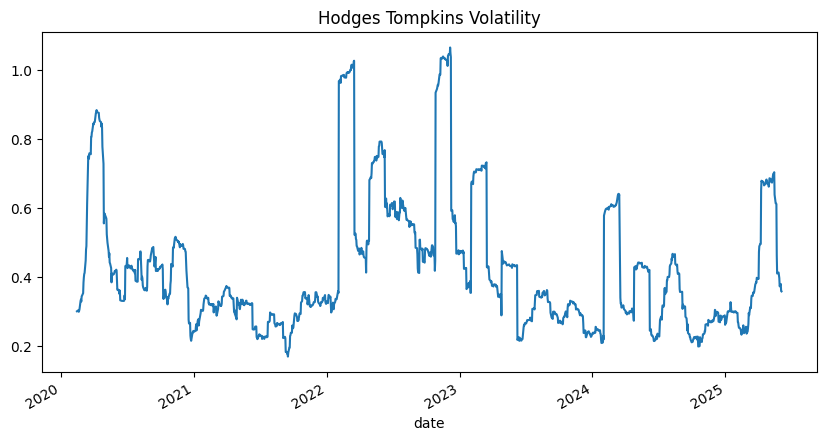

In [ ]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return result
    
# plot the result with a title
hodges_tompkins(data).plot(title='Hodges Tompkins Volatility', figsize=(10, 5));

### Rogers-Satchell

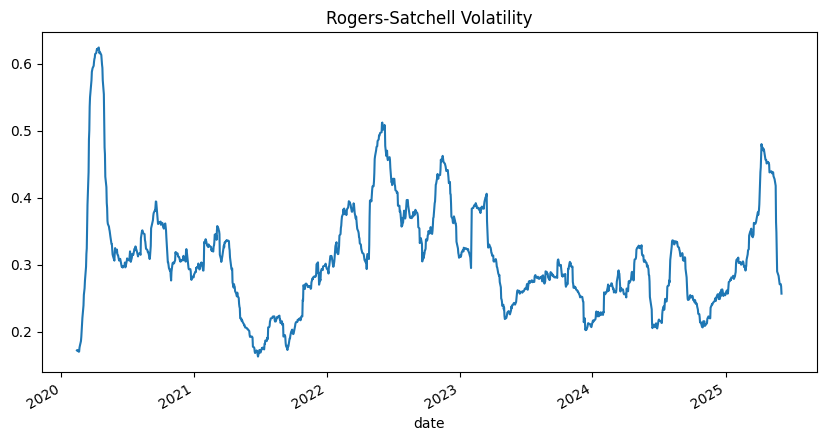

In [ ]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
    
# plot the result with a title
rogers_satchell(data).plot(title='Rogers-Satchell Volatility', figsize=(10, 5));

### Yang-Zhang

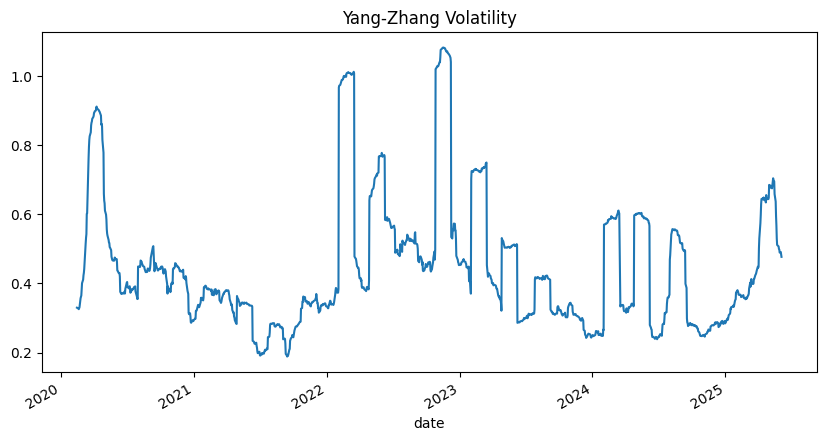

In [ ]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

# plot the result with a title
yang_zhang(data).plot(title='Yang-Zhang Volatility', figsize=(10, 5));